In [36]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage import measure, morphology

import warnings
warnings.filterwarnings("ignore")

# np.set_printoptions(threshold=np.inf)

## First Sight

In [23]:
img_dir = './img/632110.mhd'
itk_img = sitk.ReadImage(img_dir)
numpy_img = sitk.GetArrayFromImage(itk_img)
spacing = np.array(itk_img.GetSpacing())
numpy_img.shape, spacing

((54, 512, 512), array([0.68359375, 0.68359375, 5.        ]))

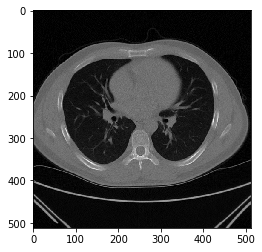

In [21]:
plt.imshow(numpy_img[27], cmap='gray')

## Binarize Image

In [6]:
img_size = numpy_img.shape[1] # 图像 x，y 是等长的（此例中为512），所以只需要知道一个就行
grid_axis = np.linspace(-img_size/2+0.5, img_size/2-0.5, img_size) # 以中点为零点，分成等长的 512 份
grid_axis.shape

(512,)

In [12]:
x, y = np.meshgrid(grid_axis, grid_axis, sparse=True) # 以图像中心为原点，把网格分成 512*512 的网格, sparse 参数节省内存
x.shape, y.shape

((1, 512), (512, 1))

In [10]:
d = (x**2+y**2)**0.5
d.shape

(512, 512)

In [ ]:
nan_mask = (d<img_size/2).astype(float) # 制造一个 mask，内切圆内为1，四个角一般没有重要组织，设为nan
nan_mask[nan_mask=0] = np.nan

In [52]:
def binarize_per_slice(img, spacing, intensity_th=-600, sigma=1, area_th=30, eccen_th=0.99, bg_patch_size=10):
    bw1 = np.zeros(img.shape, dtype=bool)
    bw2 = np.zeros(img.shape, dtype=bool)
    for i in range(img.shape[0]):
        # 查看左上角有无组织，没有就乘 mask（个人认为这步多余）
        if len(np.unique(img[i, 0:bg_patch_size, 0:bg_patch_size])) == 1:
            filtered = scipy.ndimage.filters.gaussian_filter(img[i].astype('float32') * nan_mask, sigma, truncate=2.0)
        else:
            filtered = scipy.ndimage.filters.gaussian_filter(img[i].astype('float32'), sigma, truncate=2.0)
            
        current_bw = filtered < intensity_th
        bw1[i] = current_bw # 为了查看中间状态而存储的 mask

        label = measure.label(current_bw) # current_bw 是 bool array，measure.label 为每一个联通区域编号
                                          # 返回的 label 形状和 current_bw 相同，元素替换为各自所属区域编号
        regions_props = measure.regionprops(label) # regionprops 获取每一个联通区域的性质，如像素级面积、离心率等

        valid_label = set()
        for region_props in regions_props:
            # 判断每一个联通区域的真实面积是否大于 area_th，离心率是否小于 eccen_th
            if region_props.area * spacing[1] * spacing[2] > area_th and region_props.eccentricity < eccen_th:
                valid_label.add(region_props.label) # 若满足条件，则加入 valid_label 集合

        current_bw = np.isin(label, list(valid_label)) # 查看 label 中的各区域编号是否在 valid_label 中，注意set要转换为list
        bw2[i] = current_bw # 上一步中 current_bw 再次转换为 bool array，可作为另外一个 mask，筛选合适的保留区域
    
    return bw1, bw2

有个不错的关于 eccentricity 的[回答](https://stackoverflow.com/questions/1532168/what-are-the-second-moments-of-a-region). 但是尚未完全搞明白其在图形中的几何意义. 目前理解到以下程度：看下图最右侧图的右下角有一条带被抠除，观察该条带发现 x, y 方差基本相同, 同时其相关性较高，两者的联合正态分布的等高线椭圆应该是狭长的，长短轴之比可能大于 10，因此 eccentricity > 0.99

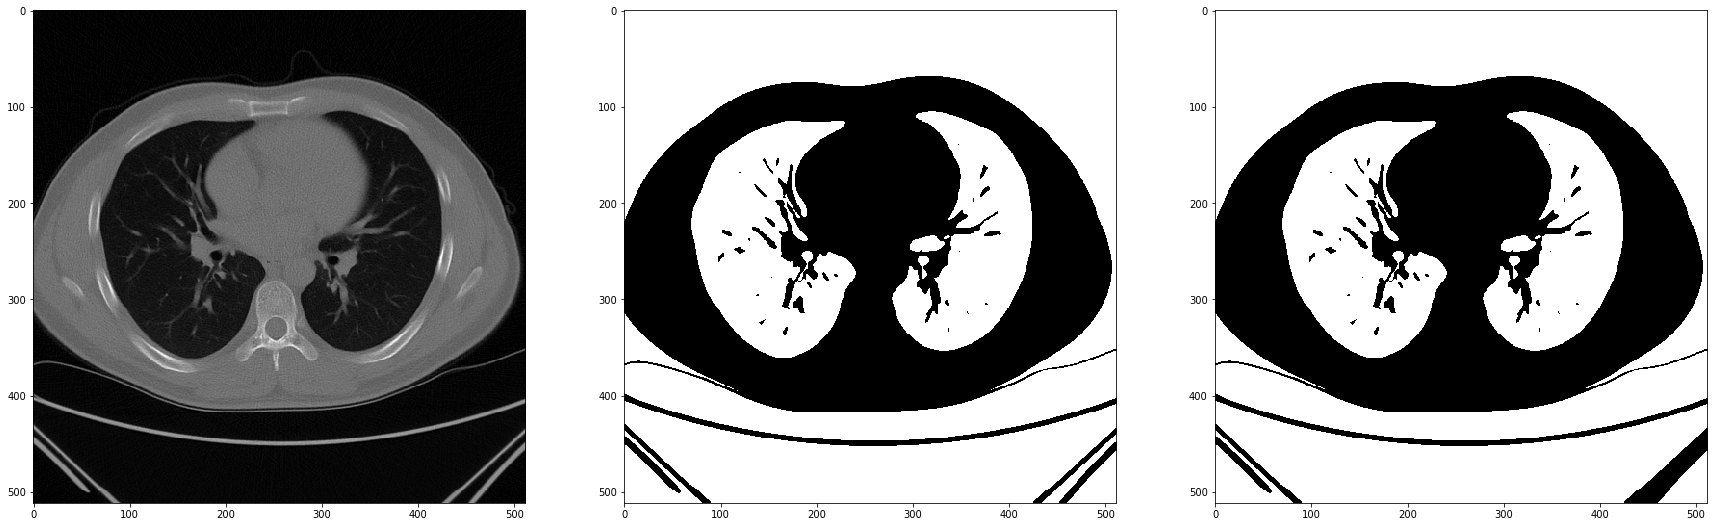

In [53]:
mask1, mask2 = binarize_per_slice(numpy_img, spacing)

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(numpy_img[27], cmap='gray')
ax[1].imshow(mask1[27], cmap='gray')
ax[2].imshow(mask2[27], cmap='gray')

In [ ]:
def all_slice_analysis(bw, spacing, cut_num=0, vol_limit=[0.68, 8.2], area_th=6e3, dist_th=62):
    pass